In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.matlib import repmat
from skimage import io
import os
import copy
import glob
import cv2
import plotly.graph_objects as go
import open3d as o3d
import json
import torch
#import open3d as o3d
from PIL import Image
from PIL import ImageFilter
#%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
import math
import os
os.chdir('../..')
from torch.utils.data import Dataset, DataLoader
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    PointsRasterizationSettings,
    OpenGLPerspectiveCameras,
    SfMPerspectiveCameras,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    MeshRasterizer
)


FOLDER = "/media/melina/Extreme SSD/Carla_0.9.11/PythonAPI/examples/output/stereo/"
DEPTH_FOLDER = "/media/melina/Extreme SSD/Carla_0.9.11/PythonAPI/examples/output/stereo/DepthMap/"
OUTPUT_FOLDER = "/media/melina/Extreme SSD/Carla_0.9.11/PythonAPI/examples/output/stereo/images/"
if not os.path.exists(DEPTH_FOLDER):
    os.makedirs(DEPTH_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-03-03 13:00:18,491 - utils - NumExpr defaulting to 8 threads.


In [2]:
def read_rgb(rgb_file):
    rgb = cv2.imread(rgb_file)
    #new_size = (int(rgb.shape[0] / 4),int(rgb.shape[0] / 4))
    #rgb = cv2.resize(rgb, new_size, interpolation=cv2.INTER_AREA) 
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    #rgb = cv2.resize(rgb, (128, 128), interpolation = cv2.INTER_AREA)
    #plt.imshow(rgb)
    #plt.title(rgb_file)
    #plt.show()
    return rgb

def read_rgb2gray(rgb_file):
    rgb = cv2.imread(rgb_file)
    #new_size = (int(rgb.shape[0] / 4),int(rgb.shape[0] / 4))
    #rgb = cv2.resize(rgb, new_size, interpolation=cv2.INTER_AREA) 
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    #rgb = cv2.resize(rgb, (128, 128), interpolation = cv2.INTER_AREA)
    #plt.imshow(rgb)
    #plt.title(rgb_file)
    #plt.show()
    return rgb

def read_seg(seg_file):
    seg = (io.imread(seg_file))[:,:,0]
    #new_size = (int(seg.shape[0] / 4),int(seg.shape[0] / 4))
    #seg = cv2.resize(seg, new_size, interpolation=cv2.INTER_AREA)
    plt.imshow(seg *100, cmap = 'gray')
    plt.title(seg_file)
    plt.show()
    return seg

def read_depth(depth_file):
    depth = io.imread(depth_file)
    #depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
    #new_size = (int(depth.shape[0] / 4),int(depth.shape[0] / 4))
    #depth = cv2.resize(depth, new_size, interpolation=cv2.INTER_AREA)
    # Reference: https://carla.readthedocs.io/en/stable/cameras_and_sensors/#camera-depth-map
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    plt.imshow(depth,'gray')
    plt.show()
    return depth

def read_depth2(depth_file):
    depth = np.load(depth_file+".npy")
    #print(depth.shape)
    #depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
    #new_size = (int(depth.shape[0] / 4),int(depth.shape[0] / 4))
    #depth = cv2.resize(depth, new_size, interpolation=cv2.INTER_AREA)
    # Reference: https://carla.readthedocs.io/en/stable/cameras_and_sensors/#camera-depth-map
    #plt.imshow(depth,'gray')
    #plt.show()
    return depth

def point_cloud_to_image(points, color ,K, width=128, height=128, transformation = None):
    points = np.transpose(points, (1,0))
    if transformation is not None:
        tmp = np.ones((4,points.shape[1]))
        tmp[:3,:] = points
        tmp = transformation @ tmp
    else:
        tmp = points
        
    tmp = K @ tmp
    tmp1 = tmp/tmp[2,:]
    # TODO:
    # Note that multiple points might be mapped to the same pixel
    # The one with the lowest depth value should be assigned to that pixel
    # However, note this has not been implemented here
    # This needs to be implemented
    u_cord = np.clip(np.round(tmp1[0,:]),0,width - 1).astype(np.int64)
    v_cord = np.clip(np.round(tmp1[1,:]),0,height - 1).astype(np.int64)
    imtmp = np.ones((height,width,3)).astype(np.int64)*255
    min_v_cord_indexes = np.where(v_cord < 0)
    v_cord[min_v_cord_indexes] = 0
    min_u_cord_indexes = np.where(u_cord < 0)
    u_cord[min_u_cord_indexes] = 0
    imtmp[v_cord, u_cord,:]= (color).astype(np.int64)
    #plt.imshow(imtmp)
    #plt.show()
    
    return imtmp
    
    
def get_rendered_image(depth, img, rel_pose12, K):
    
    rel_pose12 = rel_pose12.copy()
    rel_pose12[0:2,3] *= -1
    angles = rotationMatrixToEulerAngles(rel_pose12[:3,:3])
    rel_pose12[:3,:3] = eulerAnglesToRotationMatrix(angles * np.array([1.0,1.0, -1.0]))

    verts, color = depth_to_local_point_cloud(depth, color=img,k = K)
    
    # See also: 
    # https://github.com/facebookresearch/pytorch3d/blob/stable/docs/tutorials/render_colored_points.ipynb
    
    verts = torch.Tensor(verts).to(device)
    rgb = torch.Tensor(color).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    

    
    R = torch.from_numpy(rel_pose12[:3,:3].astype(np.float32)).unsqueeze(0)
    T = torch.FloatTensor(1*rel_pose12[:3,3].astype(np.float32)).unsqueeze(0)
    cameras = SfMPerspectiveCameras(device=device, R=R, T=T,
                                        focal_length = torch.FloatTensor([[1,1]]),
                                       principal_point = torch.FloatTensor([[0,0]]))

    raster_settings = PointsRasterizationSettings(
            image_size=(img.shape[0], img.shape[1]), 
            radius = 0.01,
            points_per_pixel = 100
        )

    renderer = PointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            compositor=AlphaCompositor()
        )
    """
    rasterizer = PointsRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )
    
    fragments = rasterizer(point_cloud).zbuf.cpu().squeeze().numpy()
    fragments = np.array(fragments,dtype = float)
    print(type(fragments))
    print(fragments.shape)
    """
    images = renderer(point_cloud)
    
    return images[0, ..., :3].cpu().numpy()


def depth_to_local_point_cloud(image, color=None, k = np.eye(3),max_depth=1.1):
    """
    Convert an image containing CARLA encoded depth-map to a 2D array containing
    the 3D position (relative to the camera) of each pixel and its corresponding
    RGB color of an array.
    "max_depth" is used to omit the points that are far enough.
    Reference: 
    https://github.com/carla-simulator/driving-benchmarks/blob/master/version084/carla/image_converter.py
    """
    far = 1000.0  # max depth in meters.
    normalized_depth = image# depth_to_array(image)
    height, width = image.shape


    # 2d pixel coordinates
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, 3)
    normalized_depth = np.reshape(normalized_depth, pixel_length)

    # Search for pixels where the depth is greater than max_depth to
    # delete them
    max_depth_indexes = np.where(normalized_depth > max_depth)
    normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    if color is not None:
        color = np.delete(color, max_depth_indexes, axis=0)

    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    p3d = np.dot(np.linalg.inv(k), p2d)
    p3d *= normalized_depth * far
    p3d = np.transpose(p3d, (1,0))
    return p3d, color / 255.0

In [3]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])*180/np.pi

# Calculates Rotation Matrix given euler angles.
def eulerAnglesToRotationMatrix(theta) :
    
    theta *= np.pi / 180
    
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
        
        
                    
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
                
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
                    
                    
    R = np.dot(R_x, np.dot( R_y, R_z ))

    return R
def compute_small_noise():   
    #x_bias = np.random.uniform(-3, 3)
    y_bias = np.random.uniform(-0.8, 0.8)
    yaw_bias = np.random.uniform(-0.07, 0.07)
    print('random transfer',0,y_bias, yaw_bias)
    return 0, y_bias, yaw_bias

def compute_large_noise():   
    #x_bias = np.random.uniform(-3, 2)
    y_bias = np.random.uniform(-2, 2)
    yaw_bias = np.random.uniform(-0.18, 0.18)
    print('random transfer',0,y_bias, yaw_bias)
    return 0, y_bias, yaw_bias

def compute_x_noise():   
    x_bias = np.random.uniform(-3, 2)
    #y_bias = np.random.uniform(-2, 2)
    #yaw_bias = np.random.uniform(-0.18, 0.18)
    print('random transfer',x_bias,0,0)
    return x_bias,0,0

def compute_TRMatrix(x,y,yaw):
    Tr = np.array([[np.cos(yaw),    -np.sin(yaw),     0,         x],
                    [np.sin(yaw),    np.cos(yaw),     0,         y],
                    [0,              0,               1,         0],
                    [0,              0,               0,         1]
                    ])
    return Tr

def compute_delta(Tr):
    delta_x = Tr[0,3]
    delta_y = Tr[1,3]
    delta_yaw = np.arcsin(Tr[1,0])
    return delta_x, delta_y, delta_yaw

def compute_Transformation(x,y,yaw):
    Tr = np.array([[np.cos(yaw), 0, np.sin(yaw), y],
                  [0,            1, 0,           0], 
                  [-np.sin(yaw), 0, np.cos(yaw), x],
                  [0,            0, 0,           1]])
    return Tr
'''
def compute_rotation(delta_yaw):
    R = np.array([[np.cos(delta_yaw),    0,      np.sin(delta_yaw),  0],
                  [0,                    1,      0               ,   0],
                  [-np.sin(delta_yaw),   0,      np.cos(delta_yaw),  0],
                  [0,                    0,      0,                  1]
                ])
    return R
'''
def center_resize(img, w, h):
    #x = img.shape[0]/2 - w/2
    y = img.shape[1]/2 - h/2
    #print(x,y)
    crop_img = img[:int(w), int(y):int(y+h),:]
    crop_img = np.array(crop_img, dtype='uint8')
    resize_img = cv2.resize(crop_img, (128, 128), interpolation=cv2.INTER_AREA)
    return crop_img, resize_img

def save_image(img,flag,frame,num):
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    status = cv2.imwrite(FOLDER+'images/%02d_%04d_%02d.png'%(flag,frame,num),bgr_img)
    return status

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def save_depth(img,flag,frame):
    #normalized_depth = NormalizeData(img)
    np.save(FOLDER+'DepthMap/%02d_%04d'%(flag,frame), img)
    #status = cv2.imwrite(FOLDER+'DepthMap/%02d_%04d.png'%(flag,frame),bgr_img.astype(np.float64))
    return 

In [4]:
fh = open(FOLDER + "data.txt", 'r')
target_state = np.empty([0, 4], dtype=float)
ego_state = np.empty([0, 4], dtype=float) 
labels = []
for line in fh:                #按行循环txt文本中的内容
    line = line.rstrip()       # 删除 本行string 字符串末尾的指定字符，默认为空格 
    words = line.split()   #通过指定分隔符对字符串进行切片 
    target_state = np.append(target_state, np.array([[float(words[1]), float(words[2]),\
                                                  float(words[3]), float(words[4])]]), axis=0)
    ego_state = np.append(ego_state, np.array([[float(words[5]), float(words[6]),\
                                                  float(words[7]), float(words[8])]]), axis=0)
    labels.append([words[0], float(words[9]), float(words[10])])

In [5]:
print(len(ego_state))
print(labels[0])

8000
['images/00_0000.png', 0.9999999999995881, 0.1621691630536713]


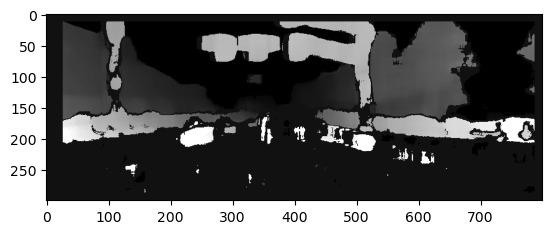

/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


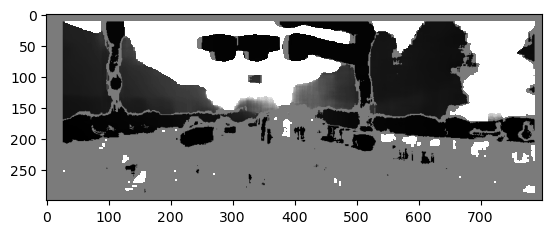

Saved!
FINISH!


In [6]:
FLAG = 7
for f in range(1):
    for Frame in range(1):
        imgL = os.path.join(FOLDER, "RGB1/%02d_%04d.png"%(f, Frame))
        imgR = os.path.join(FOLDER, "RGB2/%02d_%04d.png"%(f, Frame))
        rgbL = read_rgb2gray(imgL)
        rgbR = read_rgb2gray(imgR)
        stereo = cv2.StereoBM_create(numDisparities=16, blockSize=25)
        disparity = stereo.compute(rgbL,rgbR).astype(np.float64)
        disparity[np.where(disparity<0)] *= -1
        #disparity[np.where(disparity==0)] += 0.01
        #print(np.max(disparity))
        #print(np.min(disparity))
        plt.imshow(disparity,'gray')
        plt.show()

        disparity = (0.5*10)/(disparity)
        #disparity /=3
        #disparity[np.where(disparity<0)] *= -1
        #disparity = NormalizeData(disparity)
        plt.imshow(disparity,'gray')
        plt.show()

        #save image to disk
        #save_depth(disparity, f, Frame)
    print('Saved!')

print('FINISH!')

FLAG 0
0
random transfer 0 -0.6131616495826511 -0.02780331030035857
original delta 7.999834624254959 0.051439134634784 1.2511068330405683e-20
delta data 10.999834624254959 0.051439134634784 1.2511068330405683e-20
0.625
Point Coud 1, projected back to image 2


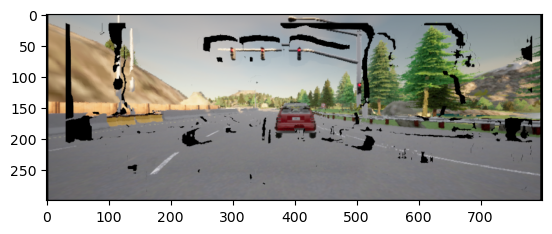

Resized image


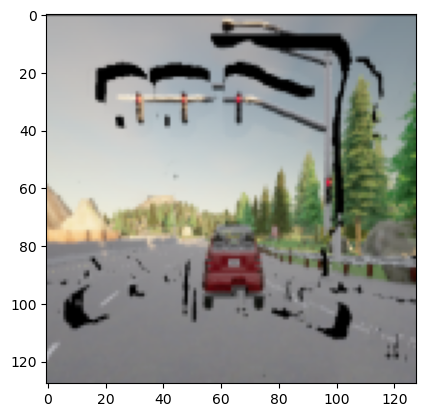

In [15]:
intrinsics_file = os.path.join(FOLDER,"camera_intrinsic.json")
extrinsics_file = os.path.join(FOLDER,"data.txt")

with open(intrinsics_file) as f:
    K = json.load(f)
K = np.array(K) 
#print(K)

N_sample = 1

for f in range(1):
    
    print('FLAG', f)

    for Frame in range(1):
        print(Frame)
        #Frame = 50
        #frame = format(Frame, '04d')

        rgb_file1   = os.path.join(FOLDER, "RGB1/%02d_%04d.png"%(f, Frame))
        rgb_file2   = os.path.join(FOLDER, "RGB1/%02d_%04d.png"%(f, Frame))
        depth_file1 = os.path.join(FOLDER, "DepthMap/%02d_%04d"%(f, Frame))
        depth_file2 = os.path.join(FOLDER, "DepthMap/%02d_%04d"%(f, Frame))    

        # get the state of the target vehicle
        xt, yt, yawt, vt = target_state[f*1000+Frame]
        #print(xt, yt, yawt)
        #get the state of the ego vehicle
        x1, y1, yaw1, v1 = ego_state[f*1000+Frame]
        #print(x1, y1, yaw1)

        for i in range(N_sample):
            #set random transfer
            if i <= 1:
                noise_x, noise_y, noise_yaw = compute_small_noise() 
                #noise_x, noise_y, noise_yaw = 0,-5,0.18
            elif i<= 3:
                noise_x, noise_y, noise_yaw = compute_large_noise()
            elif i == 4:
                noise_x, noise_y, noise_yaw = 0,0,0    #compute the original transformation
            else:
                noise_x, noise_y, noise_yaw = compute_x_noise()
            noise_x = -3
            noise_y = 0
            noise_yaw = 0
            #print(x2, y2, yaw2)

            ###compute the ground truth transformation
            poseT = compute_TRMatrix(xt, yt, yawt)    #target extrinsic in carla coordinates
            poseE1 = compute_TRMatrix(x1, y1, yaw1)   #ego extrinsic
            TrET1 = np.linalg.inv(poseE1) @ (poseT)   
            delta_x, delta_y, delta_yaw = compute_delta(TrET1)   #relative transformation
            print('original delta', delta_x, delta_y, delta_yaw)
            poseT2 = compute_TRMatrix(delta_x, delta_y, delta_yaw)   #target extrinsic in ego coordinates
            poseE2 = compute_TRMatrix(noise_x, noise_y, noise_yaw)   #trans ego extrinsic in ego coordinates
            TrET2 = np.linalg.inv(poseE2) @ (poseT2)  
            delta_x, delta_y, delta_yaw = compute_delta(TrET2)
            print('delta data', delta_x, delta_y, delta_yaw)
            '''
            #compute the ground truth transformation
            poseT = compute_TRMatrix(xt, yt, yawt)
            poseE2 = compute_TRMatrix(x2, y2, yaw2)
            TrET2 = np.linalg.inv(poseE2) @ (poseT)
            InvE2 = np.linalg.inv(poseE2)
            print(poseE2)
            print(InvE2)
            print(poseE2@InvE2)
            delta_x, delta_y, delta_theta = compute_delta(TrET2)
            print('delta data', delta_x, delta_y, delta_theta)
            '''
            #### get the rendered image
            pose1 = compute_Transformation(0,0,0)   #original ego vehicle extrinsic matrix
            pose2 = compute_Transformation(noise_x, noise_y, noise_yaw)   #transfered extrinsic matrix
            #R = compute_rotation(noise_yaw)          #random rotation matrix

            rel_pose12 = np.linalg.inv(pose2) @ (pose1)


            rgb1 = read_rgb(rgb_file1)
            #print(rgb1.shape)
            rgb2 = read_rgb(rgb_file2)
            # Note that the depth values below are normalized to between 0 and 1. 
            depth1 = read_depth2(depth_file1) 
            depth2 = read_depth2(depth_file2) 
            
            max_depth_indexes = np.where(depth1 > 1000)
            depth1[max_depth_indexes] = 0
            depth1[max_depth_indexes] = np.max(depth1)
            print(np.max(depth1))
            #depth1 = disparity
            #depth2 = disparity
            #print(depth1.shape)

            height, width = depth1.shape
            #height = int(height/4)
            #width = int(width/4)


            pixel_length = width * height
            u_coord = repmat(np.r_[width-1:-1:-1],
                                 height, 1).reshape(pixel_length)
            v_coord = repmat(np.c_[height-1:-1:-1],
                                 1, width).reshape(pixel_length)

            depths = depth1[v_coord, u_coord] * 1000
            color1 = rgb1[v_coord, u_coord]
            # Remove points greater than 50 meters   
            max_depth_indexes = np.where(depths > 1000)
            depths[max_depth_indexes] = 0
            depths[max_depth_indexes] = np.max(depths)
            #color1 = np.where(color1, max_depth_indexes, axis = 0)
            #u_coord = np.delete(u_coord, max_depth_indexes)
            #v_coord = np.delete(v_coord, max_depth_indexes)


            homogenous = np.vstack((u_coord, v_coord, np.ones_like(u_coord)))
            p3d = np.linalg.inv(K) @ (homogenous*depths)
            pc1InRef2 = (rel_pose12 @ np.vstack((p3d, np.ones_like(u_coord))))[:3,:]

            print("Point Coud 1, projected back to image 2")
            #pc1InRef2 = pc1InRef2 /4
            proj_img = point_cloud_to_image(pc1InRef2.T,color1 ,K,width,height,transformation = None)
            #print("Image 2 Rendered from Image 1")

            # Point Cloud of Image2
            pixel_length = width * height

            u_coord = repmat(np.r_[width-1:-1:-1],
                                 height, 1).reshape(pixel_length)
            v_coord = repmat(np.c_[height-1:-1:-1],
                                 1, width).reshape(pixel_length)

            depths = depth2[v_coord, u_coord] * 1000
            color2 = rgb2[v_coord, u_coord]

            # Remove points greater than 50 meters  
            max_depth_indexes = np.where(depths > 1000)
            depths[max_depth_indexes] = 0
            depths[max_depth_indexes] = np.max(depths)
            #color2 = np.delete(color2, max_depth_indexes, axis = 0)
            #u_coord = np.delete(u_coord, max_depth_indexes)
            #v_coord = np.delete(v_coord, max_depth_indexes)

            homogenous = np.vstack((u_coord, v_coord, np.ones_like(u_coord)))
            p3d = np.linalg.inv(K) @ (homogenous*depths)
            #print(p3d.shape)
            rendered_image = (get_rendered_image(depth1, rgb1, rel_pose12, K) * 255).astype(np.int64)
            #rendered_image[np.where(rendered_image[:,:,0] == 0)] = 255  #fill the black parts with white
            plt.imshow(rendered_image)
            plt.show()

            #center crop and resize the img
            
            crop_img, resize_img = center_resize(rendered_image, 250, 400)
            #print("Cropped image")
            #plt.imshow(crop_img)
            #plt.show()
            print("Resized image")
            plt.imshow(resize_img)
            plt.show()
            '''
            #save image to disk
            status = save_image(resize_img, f, Frame, i)
            if status == True:
                print('saved to disk')

            #write data to the file
            f_data = open(FOLDER+'delta_data.txt','a+')
            print('images/%02d_%04d_%02d.png'%(f, Frame, i), vt, v1,
                  delta_x, delta_y, delta_yaw,file = f_data)
            f_data.close()
            '''

In [50]:
print(p3d.shape)
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(p3d.T)
point_cloud1.colors = o3d.utility.Vector3dVector(color2 / 255)
#point_cloud1.paint_uniform_color([1, 0.706, 0])
o3d.io.write_point_cloud(FOLDER+"point_clouds/pc_{}_1.ply".format(2), point_cloud1)
o3d.visualization.draw_geometries([point_cloud1])

(3, 240000)


In [38]:
print(p3d.shape)
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(p3d.T)
point_cloud1.colors = o3d.utility.Vector3dVector(color2 / 255)
#point_cloud1.paint_uniform_color([1, 0.706, 0])
o3d.io.write_point_cloud(FOLDER+"/point_clouds/pc_{}_1.ply".format(2), point_cloud1)
o3d.visualization.draw_geometries([point_cloud1])

(3, 240000)


In [198]:
print(rgb1.shape)

(300, 800, 3)
